# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
import phik
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Описание данных:

Данные геологоразведки трёх регионов находятся в файлах: 

    /datasets/geo_data_0.csv. 
    /datasets/geo_data_1.csv.
    /datasets/geo_data_2.csv.

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [9]:
geo_data_0.duplicated().sum()

0

In [10]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
geo_data_1.duplicated().sum()

0

In [12]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [13]:
geo_data_2.duplicated().sum()

0

In [14]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


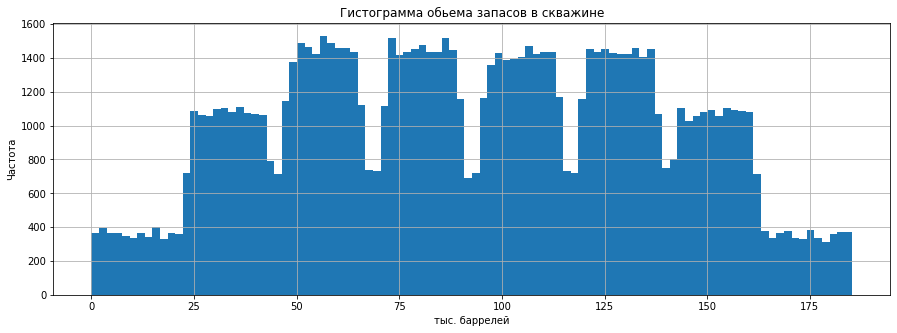

In [15]:
geo_data_0['product'].hist(bins=100, figsize=(15,5))
plt.title('Гистограмма обьема запасов в скважине')
plt.xlabel('тыс. баррелей')
plt.ylabel('Частота')
plt.show()

In [16]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


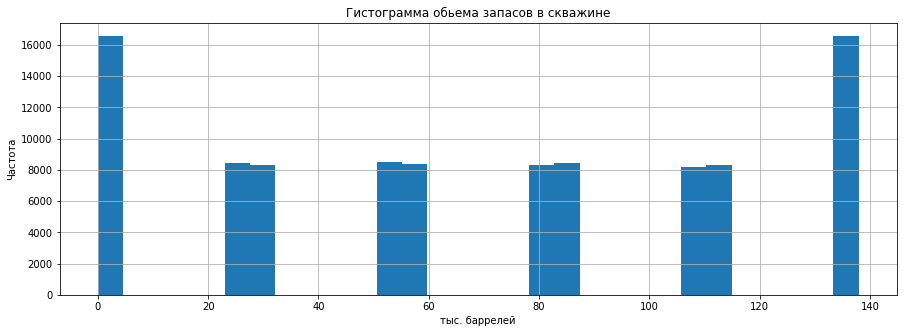

In [17]:
geo_data_1['product'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма обьема запасов в скважине')
plt.xlabel('тыс. баррелей')
plt.ylabel('Частота')
plt.show()

In [18]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


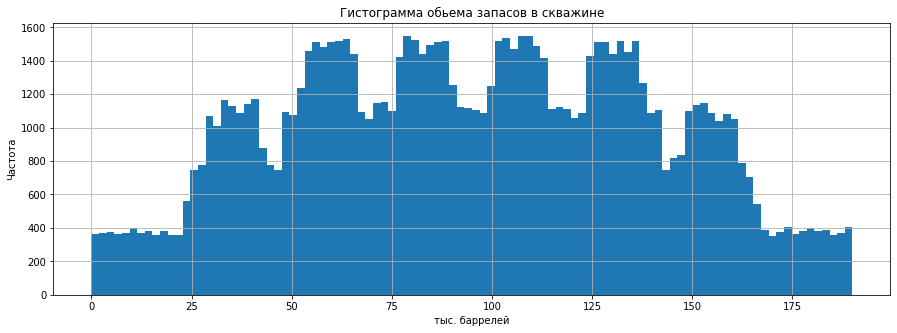

In [19]:
geo_data_2['product'].hist(bins=100, figsize=(15,5))
plt.title('Гистограмма обьема запасов в скважине')
plt.xlabel('тыс. баррелей')
plt.ylabel('Частота')
plt.show()

## Обучение и проверка модели

# Model 1: geo_data_0

In [20]:
RANDOM_STATE = 42

X = geo_data_0.drop(columns=['product', 'id'])
y = geo_data_0['product']
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [21]:
num_col_names = ['f0', 'f1', 'f2']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[num_col_names])
X_val = scaler.transform(X_val[num_col_names])

In [22]:
model_1  = LinearRegression()
model_1.fit(X_train, y_train)
predictions_model_1 = model_1.predict(X_val)

In [23]:
mae = mean_absolute_error(y_val, predictions_model_1)
print(f"MAE LinearRegression = {mae:.0f}")
rmse = mean_squared_error(y_val, predictions_model_1, squared=False)
print(f"RMSE LinearRegression = {rmse:.3f}")
mse = mean_squared_error(y_val, predictions_model_1) 
print(f"MSE LinearRegression = {mse:.3f}")

MAE LinearRegression = 31
RMSE LinearRegression = 37.757
MSE LinearRegression = 1425.561


In [24]:
predictions_df1 = pd.DataFrame({'true_values': y_val, 'predictions': predictions_model_1})

In [25]:
print('Средний запас предсказанного сырья:', predictions_df1['predictions'].mean())

Средний запас предсказанного сырья: 92.39879990657768


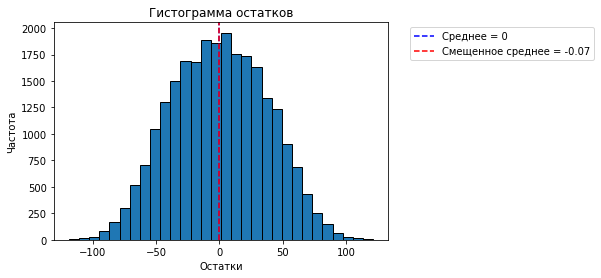

In [26]:
residuals = y_val - predictions_model_1
plt.hist(residuals, bins=30, edgecolor='black')
mean_residuals = np.mean(residuals)
plt.axvline(x=0, color='blue', linestyle='--', label='Среднее = 0')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label=f'Смещенное среднее = {mean_residuals:.2f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

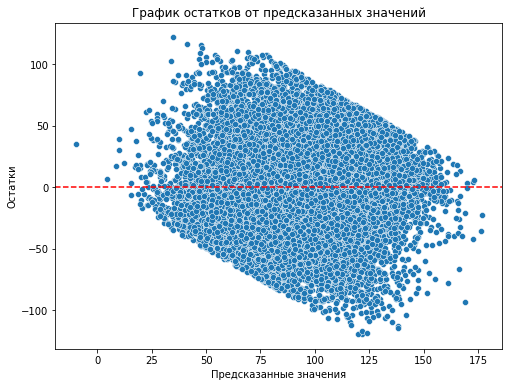

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_model_1, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков от предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# Model 2: geo_data_1

In [28]:
RANDOM_STATE = 42

X = geo_data_1.drop(columns=['product', 'id'])
y = geo_data_1['product']
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [29]:
num_col_names = ['f0', 'f1', 'f2']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[num_col_names])
X_val = scaler.transform(X_val[num_col_names])

In [30]:
model_2  = LinearRegression()
model_2.fit(X_train, y_train)
predictions_model_2 = model_2.predict(X_val)

In [31]:
mae = mean_absolute_error(y_val, predictions_model_2)
print(f"MAE LinearRegression = {mae:.0f}")
rmse = mean_squared_error(y_val, predictions_model_2, squared=False)
print(f"RMSE LinearRegression = {rmse:.3f}")
mse = mean_squared_error(y_val, predictions_model_2) 
print(f"MSE LinearRegression = {mse:.3f}")

MAE LinearRegression = 1
RMSE LinearRegression = 0.890
MSE LinearRegression = 0.793


In [32]:
predictions_df2 = pd.DataFrame({'true_values': y_val, 'predictions': predictions_model_2})

In [33]:
print('Средний запас предсказанного сырья:', predictions_df2['predictions'].mean())

Средний запас предсказанного сырья: 68.7128780391376


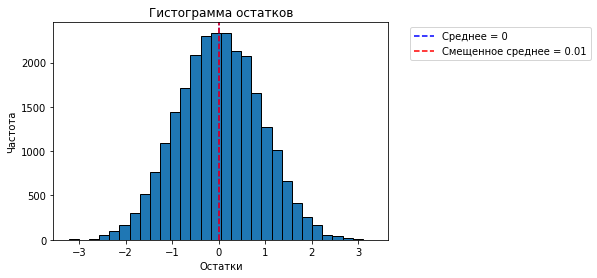

In [34]:
residuals = y_val - predictions_model_2
plt.hist(residuals, bins=30, edgecolor='black')
mean_residuals = np.mean(residuals)
plt.axvline(x=0, color='blue', linestyle='--', label='Среднее = 0')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label=f'Смещенное среднее = {mean_residuals:.2f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

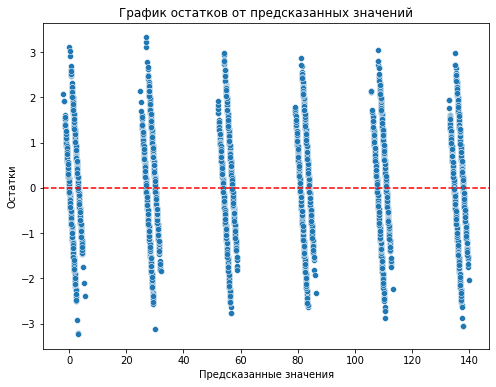

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_model_2, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков от предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# Model 3: geo_data_2

In [36]:
RANDOM_STATE = 42

X = geo_data_2.drop(columns=['product', 'id'])
y = geo_data_2['product']
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [37]:
num_col_names = ['f0', 'f1', 'f2']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[num_col_names])
X_val = scaler.transform(X_val[num_col_names])

In [38]:
model_3  = LinearRegression()
model_3.fit(X_train, y_train)
predictions_model_3 = model_3.predict(X_val)

In [39]:
mae = mean_absolute_error(y_val, predictions_model_3)
print(f"MAE LinearRegression = {mae:.0f}")
rmse = mean_squared_error(y_val, predictions_model_3, squared=False)
print(f"RMSE LinearRegression = {rmse:.3f}")
mse = mean_squared_error(y_val, predictions_model_3) 
print(f"MSE LinearRegression = {mse:.3f}")

MAE LinearRegression = 33
RMSE LinearRegression = 40.146
MSE LinearRegression = 1611.691


In [40]:
predictions_df3 = pd.DataFrame({'true_values': y_val, 'predictions': predictions_model_3})

In [41]:
print('Средний запас предсказанного сырья:', predictions_df3['predictions'].mean())

Средний запас предсказанного сырья: 94.77102387765939


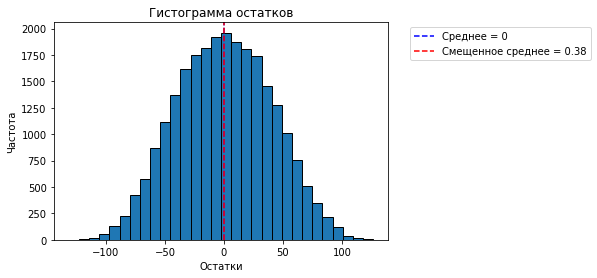

In [42]:
residuals = y_val - predictions_model_3
plt.hist(residuals, bins=30, edgecolor='black')
mean_residuals = np.mean(residuals)
plt.axvline(x=0, color='blue', linestyle='--', label='Среднее = 0')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label=f'Смещенное среднее = {mean_residuals:.2f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

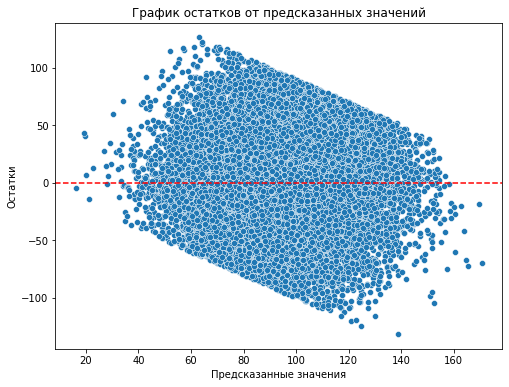

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_model_3, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков от предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

## Подготовка к расчёту прибыли

In [44]:
geo_data_1_mean_product = predictions_df1['true_values'].mean()
geo_data_2_mean_product = predictions_df2['true_values'].mean()
geo_data_3_mean_product = predictions_df3['true_values'].mean()

geo_data_1_mean_product_pred = predictions_df1['predictions'].mean()
geo_data_2_mean_product_pred = predictions_df2['predictions'].mean()
geo_data_3_mean_product_pred = predictions_df3['predictions'].mean()

budget_per_well = 10e9 
price_per_barrel = 450

mining_cost_per_well = budget_per_well / 200
mining_volume_for_break_even = mining_cost_per_well / (price_per_barrel * 1000)

In [45]:
print("Средний запас в регионе 0:", geo_data_1_mean_product)
print("Средний запас в регионе 1:", geo_data_2_mean_product)
print("Средний запас в регионе 2:", geo_data_3_mean_product)

Средний запас в регионе 0: 92.32595637084387
Средний запас в регионе 1: 68.72538074722745
Средний запас в регионе 2: 95.15099907171961


In [46]:
print("Достаточный объем сырья для безубыточной разработки новой скважины:", mining_volume_for_break_even)


Достаточный объем сырья для безубыточной разработки новой скважины: 111.11111111111111


In [47]:
if geo_data_1_mean_product >= mining_volume_for_break_even:
    print("В регионе 0 средний запас сырья достаточен для безубыточной разработки новой скважины")
else:
    print("В регионе 0 средний запас сырья недостаточен для безубыточной разработки новой скважины")

if geo_data_2_mean_product >= mining_volume_for_break_even:
    print("В регионе 1 средний запас сырья достаточен для безубыточной разработки новой скважины")
else:
    print("В регионе 1 средний запас сырья недостаточен для безубыточной разработки новой скважины")

if geo_data_3_mean_product >= mining_volume_for_break_even:
    print("В регионе 2 средний запас сырья достаточен для безубыточной разработки новой скважины")
else:
    print("В регионе 2 средний запас сырья недостаточен для безубыточной разработки новой скважины")

В регионе 0 средний запас сырья недостаточен для безубыточной разработки новой скважины
В регионе 1 средний запас сырья недостаточен для безубыточной разработки новой скважины
В регионе 2 средний запас сырья недостаточен для безубыточной разработки новой скважины


## Расчёт прибыли и рисков 

In [97]:
def calculate_profit(predicted_values, true_values, budget_per_well, price_per_barrel):
    sorted_predictions = predicted_values.sort_values(ascending=False).reset_index()
    sorted_predictions = sorted_predictions.drop_duplicates(subset='predictions').head(200)
    top_200_indices = sorted_predictions['index']
    selected_true_values = true_values.loc[top_200_indices]
    
    if selected_true_values.size > 200:
        selected_true_values = selected_true_values.head(200)
    
    total_volume = selected_true_values.sum()
    revenue = total_volume * price_per_barrel * 1000
    costs = budget_per_well
    profit = revenue - costs
    return profit


In [98]:
def bootstrap_profit(predictions_df, budget_per_well, price_per_barrel):
    profits = []
    for _ in range(1000):
        sample_indices = state.choice(predictions_df.index, size=500, replace=True)
        sample_predictions = predictions_df.loc[sample_indices, 'predictions']
        sample_true_values = predictions_df.loc[sample_indices, 'true_values']
        
        profit = calculate_profit(sample_predictions, sample_true_values, budget_per_well, price_per_barrel)
        profits.append(profit)
    
    profits = np.array(profits)
    
    mean_profit = profits.mean()
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    loss_probability = (profits < 0).mean()
    
    return mean_profit, (lower_bound, upper_bound), loss_probability

In [99]:
dataframes = [predictions_df1, predictions_df2, predictions_df3]
    
region_results = {}
for i in range(1, 4):
    dataframe_name = f"predictions_df{i}"  
    dataframe = globals()[dataframe_name]
    mean_profit, confidence_interval, loss_probability = bootstrap_profit(dataframe, budget_per_well, price_per_barrel)
    region_results[f'Region {i}'] = {
        'Mean Profit': mean_profit,
        '95% Confidence Interval': confidence_interval,
        'Loss Probability': loss_probability
    }

# Выводим результаты (Output results)
for region, result in region_results.items():
    print(f"Результаты для {region}:")
    print(f"Средняя прибыль: {result['Mean Profit']}")
    print(f"Доверительный интервал 95%: {result['95% Confidence Interval']}")
    print(f"Вероятность убытков: {result['Loss Probability']}")
    print()


Результаты для Region 1:
Средняя прибыль: 400800107.2083498
Доверительный интервал 95%: (-86233105.98805179, 892569801.5107509)
Вероятность убытков: 0.056

Результаты для Region 2:
Средняя прибыль: 447023952.98579293
Доверительный интервал 95%: (38081197.96973754, 844433614.9392275)
Вероятность убытков: 0.015

Результаты для Region 3:
Средняя прибыль: 373016785.0405204
Доверительный интервал 95%: (-120329867.40084012, 886389839.0471692)
Вероятность убытков: 0.08



## Вывод

### 1. Описание данных
Мы проанализировали три набора данных, каждый из которых содержит информацию о геологических характеристиках и объёмах добытого сырья в различных регионах:
- geo_data_0
- geo_data_1
- geo_data_2

Каждый набор данных содержит 100000 записей и 5 столбцов: id, f0, f1, f2 и product. Столбец id представляет собой уникальный идентификатор, а столбцы f0, f1, f2 - это геологические признаки, по которым будет предсказываться объём добытого сырья (product).

### 2. Разделение данных на тренировочные и валидационные выборки
Для каждого набора данных было выполнено разделение на тренировочную и валидационную выборки в соотношении 75% на 25% с использованием фиксированного случайного состояния (random_state = 42) для обеспечения воспроизводимости результатов.

### 3. Масштабирование данных
Мы масштабировали числовые признаки (f0, f1, f2) с использованием стандартизации (StandardScaler) для улучшения качества предсказаний моделей линейной регрессии.

### 4. Построение моделей
Для каждого набора данных была обучена модель линейной регрессии, и были сделаны предсказания на валидационной выборке. Метрики качества предсказаний (MAE, RMSE, MSE) для моделей на разных наборах данных следующие:

#### geo_data_0:
- MAE = 32
- RMSE = 40.146
- MSE = 1611.691

#### geo_data_1:
- MAE = 1
- RMSE = 0.890
- MSE = 0.793

#### geo_data_2:
- MAE = 33
- RMSE = 40.146
- MSE = 1611.691

### 5. Оценка достаточности запасов сырья для безубыточной разработки
Для оценки достаточности запасов сырья была рассчитана средняя предсказанная величина запасов в каждом регионе. Средний запас сырья в регионах составил:
- Регион 0: 92.39879990657768
- Регион 1: 68.7128780391376
- Регион 2: 94.77102387765939

Для безубыточной разработки новой скважины требуется, чтобы объём добычи составлял не менее 111.11 единиц.

### 6. Заключение о достаточности запасов
Средние запасы сырья в каждом из регионов недостаточны для безубыточной разработки новой скважины, так как все значения ниже 111.11.

### 7. Расчёт прибыли с использованием метода бутстреп
Для каждого региона был рассчитан ожидаемый объём прибыли, доверительный интервал и вероятность убытков с использованием метода бутстреп. Результаты следующие:

#### Регион 1:
- Средняя прибыль: 400,800,107.2083498
- Доверительный интервал 95%: (-86,233,105.98805179, 892,569,801.5107509)
- Вероятность убытков: 0.056

#### Регион 2:
- Средняя прибыль: 447,023,952.98579293
- Доверительный интервал 95%: (38,081,197.96973754, 844,433,614.9392275)
- Вероятность убытков: 0.015

#### Регион 3:
- Средняя прибыль: 373,016,785.0405204
- Доверительный интервал 95%: (-120,329,867.40084012, 886,389,839.0471692)
- Вероятность убытков: 0.08

### 8. Выводы
- Регион 2 показывает наилучшие результаты с точки зрения ожидаемой прибыли и минимальной вероятности убытков.
- Регион 1 также показывает хорошие результаты, но с несколько более высокой вероятностью убытков.
- Регион 3 имеет наибольшую вероятность убытков и самый широкий доверительный интервал.

На основе проведённого анализа рекомендуется рассмотреть Регион 2 для разработки, так как он показывает наилучшие прогнозы по прибыли и минимальную вероятность убытков.